<div style="color:#3c4d5a; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Algoritmos genéticos para problemas de clasificación o regresión. Aplicación en predicción de otorgamiento de créditos</h1> </div>

En esta práctica aprenderás a aplicar Algoritmos Genéticos (AG) en problemas de clasificación y regresión. El algoritmo genético se aplicará para predecir si un cliente en un banco es un cliente adecuado (bueno-bajo riesgo) o un cliente no adecuado (malo-alto riesgo) para otorgarle un crédito. Para ello, seguirás un proceso de análisis de datos en fases. Fase 1: preparación de datos. Fase 2: aprendizaje con AG. 

<div id="Preparacion" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Fase 1: Preparación de datos</h2> </div>

In [45]:
from time import time
from datetime import datetime, timedelta
import pandas as pd  
import numpy as np  
from matplotlib import*
from matplotlib.cm import register_cmap
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from scipy import stats
from sklearn.decomposition import PCA as sklearnPCA
import seaborn
from sklearn import set_config  
import random
print('Módulos importados')

Módulos importados


In [164]:
# Funciones para guardar y cargar un Pipeline o Modelo
def guardarPipeline(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def transformarVariables(dataframe, categorical_ordinal_features, categorical_nominal_features, numeric_features, salida):
    dataframeTransformado=copy.deepcopy(dataframe)
    cantidadTotalVariables = len(dataframeTransformado.columns) 
    print('Cantidad de variables antes de transformación de variables: ',cantidadTotalVariables)
    cantidadVariablesNominales = len(categorical_nominal_features)
    cantidadVariablesBinarias=0
    for variable in categorical_nominal_features:
        cantidadVariablesBinarias=cantidadVariablesBinarias+dataframeTransformado[variable].nunique()
    print('Cantidad de variables binarias: ',cantidadVariablesBinarias)
    cantidadTotalVariablesConTransformacion = cantidadTotalVariables - cantidadVariablesNominales + cantidadVariablesBinarias
    print('Cantidad de variables que habrá después de transformación de variables: ',cantidadTotalVariablesConTransformacion)
    #Definición de transformadores (preprocesadores)
    #1. Preprocesador de variables categóricas a numéricas (ordinales y nominales)
    categorical_ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder())])
    categorical_nominal_transformer_ConNombres = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse = False, handle_unknown = "ignore"))])# se ignorará una categoría desconocida
    preprocesorCategoricoNumericoConNombres = ColumnTransformer(
        transformers=[
            ('catord', categorical_ordinal_transformer, categorical_ordinal_features),
            ('catnom', categorical_nominal_transformer_ConNombres, categorical_nominal_features)
        ],remainder='passthrough',n_jobs=-1)
    #2. Normalización y Scaling: Preprocesador de variables numéricas con transformación MinMaxScaler
    minmax_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler(feature_range=(0, 1)))])
    preprocesorMinMax = ColumnTransformer(transformers =[
        ('tranminmax', minmax_transformer, list(range(cantidadTotalVariablesConTransformacion)))
    ], remainder ='passthrough')
    #3. Estandarización: Preprocesador de variables numéricas con transformación StandardScaler
    standardscaler_transformer = Pipeline(steps=[
        ('scaler', StandardScaler(with_mean=True,with_std=True))])
    preprocesorStandardScaler = ColumnTransformer(transformers =[
        ('transcaler', standardscaler_transformer, list(range(cantidadTotalVariablesConTransformacion)))
    ], remainder ='passthrough')
    #Construcción de Pipeline con transformadores
    pipe = Pipeline(steps=[
        ('prepcn', preprocesorCategoricoNumericoConNombres), 
        #('prepstandard', preprocesorStandardScaler)
        ('prepminmax', preprocesorMinMax)
    ])
    #Transformación de variables
    X_Transformado = pipe.fit_transform(dataframeTransformado)
    print('********** Pipeline aplicado')
    guardarPipeline(pipe,'pipePreprocesadores')
    set_config(display='diagram')
    #Formación de dataframe transformado
    cnamesDataset1=[]
    cnamesDataset1.extend(categorical_ordinal_features)
    cnamesDataset2 = pipe.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
    cnamesDataset3 = numeric_features
    cnamesDataset1.extend(cnamesDataset2)
    cnamesDataset1.extend(cnamesDataset3)
    #print(cnamesDataset1)
    dataframeTransformado = pd.DataFrame(data=X_Transformado,columns=cnamesDataset1)
    dataframeTransformado = pd.concat([dataframeTransformado, salida], axis = 1)
    return dataframeTransformado, pipe

def transformarPrediccion(lista):
    for i in range(len(lista)):
        desempenio=lista[i]
        if (desempenio<0.5):
            desempenio=0
        elif desempenio>=0.5:
            desempenio=1
        lista[i]=desempenio
    return lista

print('Funciones definidas')

Funciones definidas


In [4]:
nombresVariables=['ESTADOCUENTACORRIENTE','PLAZOMESESCREDITO','HISTORIALCREDITO','PROPOSITOCREDITO','MONTOCREDITO',
                  'SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO','TASAPAGO','ESTADOCIVILYSEXO','GARANTE','TIEMPORESIDENCIAACTUAL',
                  'ACTIVOS','EDAD','OTROSPLANESPAGO','VIVIENDA','CANTIDADCREDITOSEXISTENTES','EMPLEO',
                  'CANTIDADPERSONASAMANTENER','TELEFONO','TRABAJADOREXTRANJERO','TIPOCLIENTE']
#Para cargar un dataframe desde una URL
#dfOriginal = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', sep = ' ', 
#                         names=nombresVariables)
#dfOriginal = pd.read_csv("german.csv", sep=';')
dfOriginal = pd.read_csv("german.data", sep=' ', names=nombresVariables)
dfOriginal.head()

,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [5]:
dataframe=copy.deepcopy(dfOriginal)
print(dataframe.shape)
Y=dataframe['TIPOCLIENTE']
dataframe=dataframe.drop(['OTROSPLANESPAGO'], axis=1)
dataframe=dataframe.drop(['TELEFONO'], axis=1)
dataframe=dataframe.drop(['TIPOCLIENTE'], axis=1)
print(dataframe.shape)
dataframe.head()

(1000, 21)
(1000, 18)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,TIEMPORESIDENCIAACTUAL,ACTIVOS,EDAD,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TRABAJADOREXTRANJERO
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A152,2,A173,1,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A152,1,A173,1,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A152,1,A172,2,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A153,1,A173,2,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A153,2,A173,2,A201


In [8]:
#Determinación de tipos de variables
categorical_ordinal_features = ['ESTADOCUENTACORRIENTE','HISTORIALCREDITO','SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO',
                                'ESTADOCIVILYSEXO','ACTIVOS','VIVIENDA','EMPLEO']
categorical_nominal_features = ['PROPOSITOCREDITO','GARANTE','TRABAJADOREXTRANJERO']
numeric_features = ['PLAZOMESESCREDITO','MONTOCREDITO','TASAPAGO','TIEMPORESIDENCIAACTUAL','EDAD','CANTIDADCREDITOSEXISTENTES',
                    'CANTIDADPERSONASAMANTENER']
salida=Y
dataframeTransformado, pipe=transformarVariables(dataframe, categorical_ordinal_features, categorical_nominal_features, numeric_features, salida)
dataframeTransformado.to_csv("1.DatasetTransformado.csv", sep=";",index = False)
dataframeTransformado.head()

Cantidad de variables antes de transformación de variables:  18
Cantidad de variables binarias:  15
Cantidad de variables que habrá después de transformación de variables:  30
********** Pipeline aplicado


,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER,TIPOCLIENTE
0,0.000000,1.00,1.0,1.00,0.666667,0.000000,0.5,0.666667,0.0,0.0,...,1.0,0.0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1
1,0.333333,0.50,0.0,0.50,0.333333,0.000000,0.5,0.666667,0.0,0.0,...,1.0,0.0,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,2
2,1.000000,1.00,0.0,0.75,0.666667,0.000000,0.5,0.333333,0.0,0.0,...,1.0,0.0,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,1
3,0.000000,0.50,0.0,0.75,0.666667,0.333333,1.0,0.666667,0.0,0.0,...,1.0,0.0,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1
4,0.000000,0.75,0.0,0.50,0.666667,1.000000,1.0,0.666667,1.0,0.0,...,1.0,0.0,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,2


In [9]:
pipe

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('catord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['ESTADOCUENTACORRIENTE',
                                                   'HISTORIALCREDITO',
                                                   'SALDOCUENTAAHORROS',
                                                   'TIEMPOACTUALEMPLEO',
                                                   'ESTADOCIVILYSEXO',
                                                   'ACTIVOS', 'VIVIENDA',
                                                   'EMPLEO']),
                                                 ('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['PROPOSITOCREDITO',
                                                   'GARANTE',
                                                   'TRABAJADOREXTRANJERO'])])),
                ('prepminmax',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tranminmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28,
                                                   29])]))])

In [10]:
dfCorrel=dataframeTransformado.corr()
dfCorrel.head()

,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER,TIPOCLIENTE
ESTADOCUENTACORRIENTE,1.000000,0.192191,0.222867,0.106339,0.043261,-0.032260,0.022424,0.040663,-0.069559,0.064303,...,0.026758,-0.026758,-0.072013,-0.042705,-0.005280,-0.042234,0.059751,0.076005,-0.014145,-0.350847
HISTORIALCREDITO,0.192191,1.000000,0.039058,0.138225,0.042171,-0.053777,0.062095,0.010350,0.042480,0.039096,...,-0.013873,0.013873,-0.077186,-0.059905,0.044375,0.063198,0.147086,0.437066,0.011550,-0.228785
SALDOCUENTAAHORROS,0.222867,0.039058,1.000000,0.120950,0.017349,0.018948,0.006505,0.011709,-0.002348,0.112880,...,-0.007095,0.007095,0.047661,0.064630,0.021993,0.091424,0.084245,-0.021644,0.027514,-0.178943
TIEMPOACTUALEMPLEO,0.106339,0.138225,0.120950,1.000000,0.111278,0.087187,0.111126,0.101225,-0.021232,0.039358,...,0.027232,-0.027232,0.057381,-0.008367,0.126161,0.245081,0.256227,0.125791,0.097192,-0.116002
ESTADOCIVILYSEXO,0.043261,0.042171,0.017349,0.111278,1.000000,-0.006940,0.099579,-0.011956,0.014725,0.040694,...,-0.065618,0.065618,0.014789,-0.016091,0.119308,-0.027269,0.007783,0.064672,0.122165,-0.088184


<AxesSubplot:>

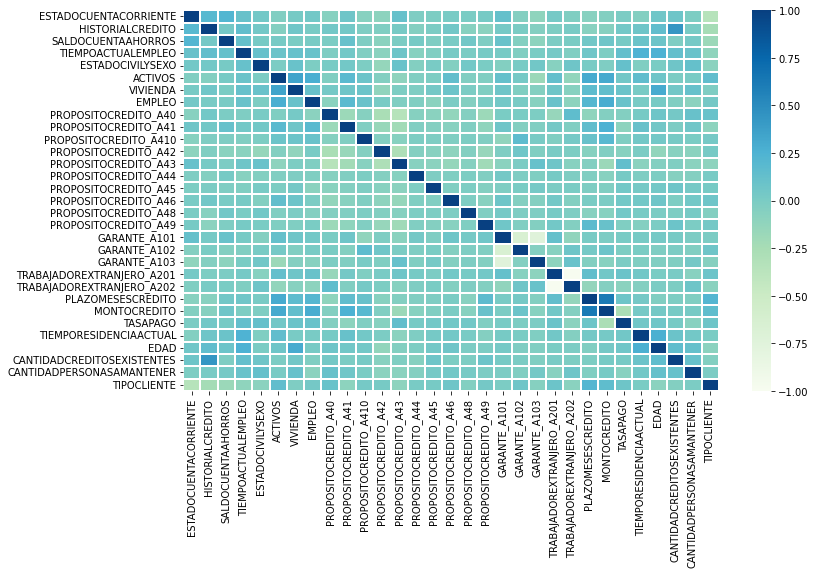

In [11]:
fig, ax = plt.subplots(figsize = (12, 7)) 
#sns.heatmap(dfCorrel, cmap ='viridis', linewidths = 0.30, annot = True)
sns.heatmap(dfCorrel, cmap ='GnBu', linewidths = 0.30, annot = False)

In [12]:
dfCorrOrdenado=dfCorrel.sort_values(by=['TIPOCLIENTE'], ascending=False)
dfCorrOrdenado['TIPOCLIENTE'].head(10)

TIPOCLIENTE                  1.000000
PLAZOMESESCREDITO            0.214927
MONTOCREDITO                 0.154739
ACTIVOS                      0.142612
PROPOSITOCREDITO_A40         0.096900
TRABAJADOREXTRANJERO_A201    0.082079
TASAPAGO                     0.072404
PROPOSITOCREDITO_A46         0.070088
GARANTE_A102                 0.062728
PROPOSITOCREDITO_A49         0.036129
Name: TIPOCLIENTE, dtype: float64

In [13]:
dfCorrOrdenado=dfCorrel.sort_values(by=['TIPOCLIENTE'], ascending=True)
dfCorrOrdenado['TIPOCLIENTE'].head(10)

ESTADOCUENTACORRIENTE       -0.350847
HISTORIALCREDITO            -0.228785
SALDOCUENTAAHORROS          -0.178943
TIEMPOACTUALEMPLEO          -0.116002
PROPOSITOCREDITO_A43        -0.106922
PROPOSITOCREDITO_A41        -0.099791
EDAD                        -0.091127
ESTADOCIVILYSEXO            -0.088184
TRABAJADOREXTRANJERO_A202   -0.082079
GARANTE_A103                -0.055039
Name: TIPOCLIENTE, dtype: float64

<div id="Fundamentos" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Fase 2: Aprendizaje con Algoritmos Genéticos</h2> </div>

In [51]:
dataframeTransformado=pd.read_csv("1.DatasetTransformado.csv", sep=";", nrows=10)
dataframeTransformado['TIPOCLIENTE'] = dataframeTransformado['TIPOCLIENTE'].replace(2, 0)
print(dataframeTransformado.shape)
dataframeTransformado.head()

(10, 31)


,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER,TIPOCLIENTE
0,0.000000,1.00,1.0,1.00,0.666667,0.000000,0.5,0.666667,0.0,0.0,...,1.0,0.0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1
1,0.333333,0.50,0.0,0.50,0.333333,0.000000,0.5,0.666667,0.0,0.0,...,1.0,0.0,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0
2,1.000000,1.00,0.0,0.75,0.666667,0.000000,0.5,0.333333,0.0,0.0,...,1.0,0.0,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,1
3,0.000000,0.50,0.0,0.75,0.666667,0.333333,1.0,0.666667,0.0,0.0,...,1.0,0.0,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1
4,0.000000,0.75,0.0,0.50,0.666667,1.000000,1.0,0.666667,1.0,0.0,...,1.0,0.0,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,0


In [52]:
Y = dataframeTransformado['TIPOCLIENTE']
dataframeTransformado=dataframeTransformado.drop(['TIPOCLIENTE'], axis=1)
#X_Transformado=dataframeTransformado.values
#X_Transformado
dataframeTransformado.head()

,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,GARANTE_A103,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER
0,0.000000,1.00,1.0,1.00,0.666667,0.000000,0.5,0.666667,0.0,0.0,...,0.0,1.0,0.0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0
1,0.333333,0.50,0.0,0.50,0.333333,0.000000,0.5,0.666667,0.0,0.0,...,0.0,1.0,0.0,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0
2,1.000000,1.00,0.0,0.75,0.666667,0.000000,0.5,0.333333,0.0,0.0,...,0.0,1.0,0.0,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0
3,0.000000,0.50,0.0,0.75,0.666667,0.333333,1.0,0.666667,0.0,0.0,...,1.0,1.0,0.0,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0
4,0.000000,0.75,0.0,0.50,0.666667,1.000000,1.0,0.666667,1.0,0.0,...,0.0,1.0,0.0,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0


In [53]:
#FUNCIONES PARA CREAR LA POBLACIÓN

def crearPoblacion(X_train, X_test):
    """
        Crea una poblacion nueva de individuos
    """
    population=X_train
    population=population.values.tolist()
    modelos=X_test
    modelos=modelos.values.tolist()
    return population, modelos

In [111]:
#FUNCION FITNESS

#Dado un individuo, la función comprueba cuántos números tiene en común con el modelo y le asigna el fitness correspondiente. 
#Después devuelve este número fuera de la función.

def calcularFitness(individual):
    """
        Calcula el fitness de un individuo concreto.
    """
    #print('indiv:', individual)
    fitness = 0
    for i in range(len(individual)):
        if individual[i] == modelo[i]:         
            fitness += 1
    #print('fitness')
    #print(fitness)       
        #coseno=funcionCoseno(modelo,individuo)
        #fitness=coseno
        
        #euclidea=funcionEuclidea(modelo,individuo)
        #fitness=euclidea
    return fitness

In [109]:
#FUNCION PARA SELECCIONAR Y EVALUAR

def selection_and_reproduction(population):
    """
        Puntua todos los elementos de la poblacion (population) y se queda con los mejores
        guardandolos dentro de 'selected'.
        Despues mezcla el material genético de los elegidos para crear nuevos individuos y
        llenar la poblacion (guardando tambien una copia de los individuos seleccionados sin
        modificar).
  
        Por ultimo muta a los individuos.
  
    """
    puntuados = [ (calcularFitness(i), i) for i in population] #Calcula el fitness de cada individuo, y lo guarda en pares ordenados de la forma (5 , [1,2,1,1,4,1,8,9,4,1])
    puntuados = [i[1] for i in sorted(puntuados)] #Ordena los pares ordenados y se queda solo con el array de valores
    population = puntuados
    
    selected =  puntuados[(len(puntuados)-pressure):] #Esta linea selecciona los 'n' individuos del final, donde n viene dado por 'pressure'
  
    #Se mezcla el material genético para crear nuevos individuos
    for i in range(len(population)-pressure):
        punto = random.randint(1,largo-1) #Se elige un punto para hacer el intercambio
        padre = random.sample(selected, 2) #Se eligen dos padres
          
        population[i][:punto] = padre[0][:punto] #Se mezcla el material genetico de los padres en cada nuevo individuo
        population[i][punto:] = padre[1][punto:]
    
    return population #El array 'population' tiene ahora una nueva poblacion de individuos, que se devuelven

In [100]:
#FUNCIÓN DE MUTACIÓN: para añadir pequeñas variaciones al azar en el array de los individuos de la nueva generación

def mutation(population):
    """
        Se mutan los individuos al azar. Sin la mutacion de nuevos genes nunca podria
        alcanzarse la solución.
    """
    for i in range(len(population)-pressure):
        if random.random() <= mutation_chance: #Cada individuo de la población (menos los padres) tienen una probabilidad de mutar
            punto = random.randint(0,largo-1) #Se elige un punto al azar
            nuevo_valor = random.randint(0,1) #y un nuevo valor para este punto
  
            #Es importante mirar que el nuevo valor no sea igual al antiguo
            while nuevo_valor == population[i][punto]:
                nuevo_valor = random.randint(0,1)
  
            #Se aplica la mutacion
            population[i][punto] = nuevo_valor
  
    return population

In [179]:
#PROCESO GA

X_train, X_test, y_train, y_test = train_test_split(dataframeTransformado, Y, test_size = 0.3)
#y_train=pd.DataFrame(data=y_train)
datasetEntrenamiento=pd.merge(X_train, y_train,left_index=True, right_index=True)
datasetTesting=pd.merge(X_test, y_test,left_index=True, right_index=True)
largo = X_train.shape[1]#La longitud del material genetico de cada individuo
num = X_train.shape[0] #La cantidad de individuos que habrá en la poblacion (conjunto de entrenamiento)
pressure = 3 #Cuantos individuos se seleccionan para reproducción. Necesariamente mayor que 2. Si quisiera ser riguroso y 
#seguir las convenciones, la variable de presión debería estar en porcentaje (un 0.3 equivaldría a seleccionar un 30% del total
#de individuos)
mutation_chance = 0.2 #La probabilidad de que un individuo mute. Es necesario que haya mutaciones para poder explorar nuevas
#soluciones que no pueden obtenerse combinando el material genético de los padres.
#print("\n\nModelo: %s\n"%(modelo)) #Mostrar el modelo, con un poco de espaciado
K=2 #cantidad de vecinos
print('Cantidad de genes: ',largo)
population, modelos = crearPoblacion(datasetEntrenamiento, datasetTesting) 
#print(population)
print('Cantidad de modelos: ',len(modelos))
print('Cantidad de individuos en la población: ',len(population))
print('Cantidad de vecinos: ',K)
y_pred=[]
#Fit con conjunto de entrenamiento
for modelo in modelos:
    #Se evoluciona la poblacion: aumentar generaciones y probar
    for i in range(1):
        population = selection_and_reproduction(population) #Evaluación, Selección, Reproducción, Crossover
        #population = mutation(population)#Mutación
        vecinos = copy.deepcopy(population)
        vecinos = vecinos[(len(vecinos)-K):]
        
        #clasificación o regresión
        #clasificación: mas frecuente
        #regresión: promedio
        prediccion = pd.DataFrame(vecinos).iloc[:,largo-1].mean() # frecuente de los 400 primeros vecinos
        y_pred.append(prediccion)
    #break#para probar con el primer modelo
y_pred = numpy.array(y_pred)
y_pred = transformarPrediccion(y_pred)
dataframeFinal=pd.DataFrame({'real':y_test, 'predicción': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal.head(10)

Cantidad de genes:  30
Cantidad de modelos:  3
Cantidad de individuos en la población:  7
Cantidad de vecinos:  2


,real,predicción
5,1,1.0
6,1,1.0
4,0,1.0


Mean Absolute Error (MAE): 0.3333
Mean Squared Error (MSE): 0.3333
Root Mean Squared Error (RMSE): 0.5774
Accuracy: 0.6666666666666666
Precision:  0.6667
Recall:  1.0
F1: 0.8
Matriz de confusión:
Verdaderos negativos:  0  Falsos positivos:  1  Falsos negativos:  0  Verdaderos positivos:  2


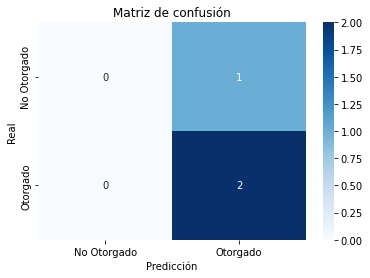

In [180]:
#EVALUACIÓN

MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase) 

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
try:
    tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()  
    print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

    from sklearn.metrics import confusion_matrix  
    labels = ['No Otorgado', 'Otorgado']
    cm = confusion_matrix(y_testBinario, y_predBinario)  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g'); #annot=True to annotate cells
    ax.set_xlabel('Predicción');ax.set_ylabel('Real'); 
    ax.set_title('Matriz de confusión'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
except:
    print('Clasificación perfecta')

In [ ]:
MAE=0.67  CON K=50
MAE=0.56  CON K=100

KVECINOS=[50,100,200,500,1000]
pressure=[50]
mutation_chance=[0.2]
fitness=['euclidea']